# ANN Model training and testing 

In [1]:
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', pdet=True)

psds not given. Choosing bilby's default psds
npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  None
ANN method is selected.
Please be patient while the interpolator is generated of partialscaledSNR for IMRPhenomD.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle


In [2]:
import numpy as np
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
luminosity_distance = np.array([1000, 2000, 3000, 4000])
# gwsnr.snr_with_ann(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)

{'L1': array([0, 0, 1, 0]),
 'H1': array([0, 0, 0, 0]),
 'V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

In [8]:
snr_bilby = gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)
gwsnr.probability_of_detection(snr_dict=snr_bilby, type='bool')

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


{'L1': array([0, 0, 1, 0]),
 'H1': array([0, 0, 0, 0]),
 'V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

## Data preprocessing

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
# check tensorflow version
print(tf.__version__)
# check sklearn version
import sklearn
print(sklearn.__version__)

2.13.1
1.3.2


In [26]:
# get data
from ler.utils import append_json, load_json
import numpy as np
unlensed_params = load_json("snr_L1.json")
# unlensed_params = load_json("joint_new_optsnr.json")
# for key, value in unlensed_params.items():
#     unlensed_params[key] = np.array(value)
# randomize the data
idx_shuffle = np.random.permutation(len(unlensed_params['L1']))
for key, value in unlensed_params.items():
    unlensed_params[key] = np.array(value)[idx_shuffle]
#snr = np.array(unlensed_params['L1'])

In [27]:
len(unlensed_params['L1'])

28113

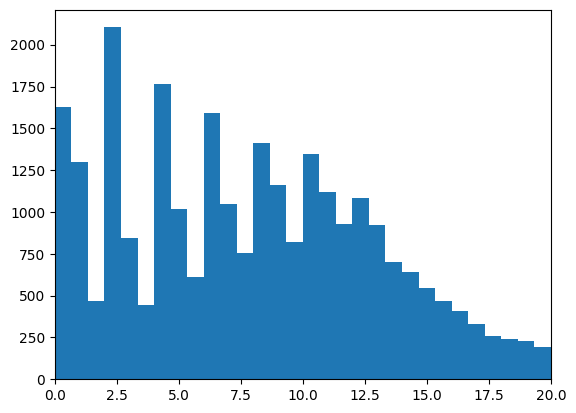

In [28]:
import matplotlib.pyplot as plt
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [29]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  None
ANN method is selected.
Please be patient while the interpolator is generated of partialscaledSNR for IMRPhenomD.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle


In [30]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    phi_12 = np.array(params['phi_12'])[idx]
    phi_jl = np.array(params['phi_jl'])[idx]

    # input data
    # X = np.vstack([L1, amp0, Mc, eta, theta_jn, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # output data
    # get L1 snr for y train 
    yL1 = params['L1'][idx]
    yH1 = params['H1'][idx]
    yV1 = params['V1'][idx]


    return(XL1, XH1, XV1, yL1, yH1, yV1)

In [31]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, XH1, XV1, yL1, yH1, yV1 = input_output(idx, unlensed_params)
np.shape(XL1)

(28113, 9)

In [32]:
# import matplotlib.pyplot as plt
# plt.hist(y[y<100], bins=100)
# plt.xlim(0,20)
# plt.show()

## Now back to ANN

### L1

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [34]:
# print(np.shape(X_train))
# print(np.shape(X_test))

In [35]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [37]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [38]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [39]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
791/791 [==============================] - 1s 497us/step - loss: 63.4480 - accuracy: 2.3714e-04
Epoch 2/200
791/791 [==============================] - 0s 498us/step - loss: 24.7348 - accuracy: 0.0000e+00
Epoch 3/200
791/791 [==============================] - 0s 496us/step - loss: 16.6748 - accuracy: 3.9524e-05
Epoch 4/200
791/791 [==============================] - 0s 486us/step - loss: 12.5886 - accuracy: 7.9048e-05
Epoch 5/200
791/791 [==============================] - 0s 487us/step - loss: 10.0020 - accuracy: 7.9048e-05
Epoch 6/200
791/791 [==============================] - 0s 487us/step - loss: 8.2039 - accuracy: 1.1857e-04
Epoch 7/200
791/791 [==============================] - 0s 515us/step - loss: 6.8957 - accuracy: 1.1857e-04
Epoch 8/200
791/791 [==============================] - 0s 500us/step - loss: 5.9086 - accuracy: 1.1857e-04
Epoch 9/200
791/791 [==============================] - 0s 493us/step - loss: 5.1250 - accuracy: 1.5810e-04
Epoch 10/200
791/791 [==========

In [40]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

88/88 [==============================] - 0s 566us/step
[[ 4.61121416  4.77777499]
 [ 7.59788942  8.27535942]
 [10.89720917 10.26178774]
 [ 8.52272606  8.20943627]
 [15.47688866 14.06081837]
 [16.4499836  16.66089685]
 [ 2.7054565   2.72369782]
 [10.51429176 11.22310476]
 [10.42868805 10.33807745]
 [ 6.90547132  7.4488752 ]]


In [43]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>6) != (y_test>6))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.20%


2812
1057


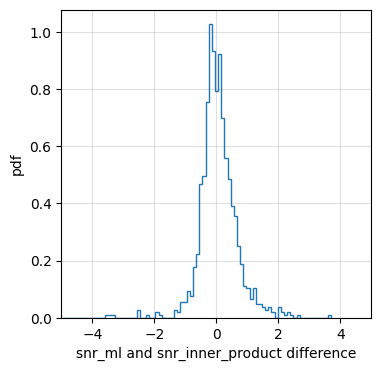

In [44]:
import matplotlib.pyplot as plt

y_pred = y_pred.flatten()
# y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [48]:
# Save the model to a file
ann.save('ann_modelL1.h5')

### H1

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [50]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [51]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [52]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
2813/2813 [==============================] - 2s 502us/step - loss: 5.9933 - accuracy: 1.3332e-04
Epoch 2/200
2813/2813 [==============================] - 1s 519us/step - loss: 1.8604 - accuracy: 2.7776e-04
Epoch 3/200
2813/2813 [==============================] - 1s 492us/step - loss: 1.2152 - accuracy: 2.8887e-04
Epoch 4/200
2813/2813 [==============================] - 1s 495us/step - loss: 0.9227 - accuracy: 3.2220e-04
Epoch 5/200
2813/2813 [==============================] - 1s 485us/step - loss: 0.7461 - accuracy: 3.1109e-04
Epoch 6/200
2813/2813 [==============================] - 1s 508us/step - loss: 0.6484 - accuracy: 2.9998e-04
Epoch 7/200
2813/2813 [==============================] - 1s 491us/step - loss: 0.5772 - accuracy: 3.3331e-04
Epoch 8/200
2813/2813 [==============================] - 1s 484us/step - loss: 0.5270 - accuracy: 3.5553e-04
Epoch 9/200
2813/2813 [==============================] - 1s 504us/step - loss: 0.4927 - accuracy: 3.1109e-04
Epoch 10/200
2813/2

In [53]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

313/313 [==============================] - 0s 338us/step
[[0.54871368 0.4168334 ]
 [2.4766047  2.12355028]
 [8.95738316 8.69730996]
 [6.19180012 5.69036995]
 [8.43137741 8.34367143]
 [8.10725498 8.23281797]
 [9.75430393 9.88966943]
 [0.77356434 0.79247159]
 [0.68909764 0.73560906]
 [7.59835768 7.79408989]]


In [54]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.13%


In [55]:
# Save the model to a file
ann.save('ann_modelH1.h5')

### V1

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [57]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [58]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [59]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
2813/2813 [==============================] - 2s 504us/step - loss: 2.4578 - accuracy: 3.5553e-04
Epoch 2/200
2813/2813 [==============================] - 1s 491us/step - loss: 0.9121 - accuracy: 5.9996e-04
Epoch 3/200
2813/2813 [==============================] - 1s 494us/step - loss: 0.6503 - accuracy: 6.6662e-04
Epoch 4/200
2813/2813 [==============================] - 1s 486us/step - loss: 0.5245 - accuracy: 6.2218e-04
Epoch 5/200
2813/2813 [==============================] - 1s 494us/step - loss: 0.4424 - accuracy: 6.5551e-04
Epoch 6/200
2813/2813 [==============================] - 1s 485us/step - loss: 0.4008 - accuracy: 6.3329e-04
Epoch 7/200
2813/2813 [==============================] - 1s 495us/step - loss: 0.3720 - accuracy: 7.2217e-04
Epoch 8/200
2813/2813 [==============================] - 1s 484us/step - loss: 0.3524 - accuracy: 5.7774e-04
Epoch 9/200
2813/2813 [==============================] - 1s 496us/step - loss: 0.3309 - accuracy: 6.8884e-04
Epoch 10/200
2813/2

In [60]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

313/313 [==============================] - 0s 283us/step
[[0.59278154 0.36724218]
 [1.04757905 1.6146172 ]
 [2.31513858 2.29060415]
 [1.77871871 1.66165015]
 [3.42865801 3.34930527]
 [5.38617277 5.337341  ]
 [4.45792341 4.79875161]
 [0.97207999 0.98978223]
 [0.45344448 0.44625305]
 [3.75552583 3.6178563 ]]


In [61]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.06%


In [62]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [63]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

In [14]:
def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'][idx])
    mass_2 = np.array(params['mass_2'][idx])
    luminosity_distance = np.array(params['luminosity_distance'][idx])
    theta_jn = np.array(params['theta_jn'][idx])
    psi = np.array(params['psi'][idx])
    geocent_time = np.array(params['geocent_time'][idx])
    ra = np.array(params['ra'][idx])
    dec = np.array(params['dec'][idx])
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'][idx])
    a_2 = np.array(params['a_2'][idx])
    tilt_1 = np.array(params['tilt_1'][idx])
    tilt_2 = np.array(params['tilt_2'][idx])
    phi_12 = np.array(params['phi_12'][idx])
    phi_jl = np.array(params['phi_jl'][idx])

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(params['L1'][idx]**2 + params['H1'][idx]**2 + params['V1'][idx]**2)

    return(X,y)

In [15]:
X_, Y_ = input_output_net(np.array([1000,1001,1002]), unlensed_params)

In [16]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)
    return(x_array,y)

In [17]:
_, snrANN =input_output_netANN(X_)

1/1 [==============================] - 0s 29ms/step


In [18]:
Y_

array([ 0.8932943 , 33.87213955,  8.96373073])

In [19]:
snrANN

array([[ 0.8874264],
       [33.258392 ],
       [ 8.21772  ]], dtype=float32)

In [20]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)

X_, Y_ = input_output_net(idx, unlensed_params)

In [21]:
_, snrANN =input_output_netANN(X_)

2414/2414 [==============================] - 1s 254us/step


In [22]:
Y_

array([29.51425335, 22.90539453,  0.28999233, ...,  0.36397475,
       14.99422556, 12.26884642])

In [23]:
snrANN

array([[30.600124  ],
       [26.772612  ],
       [ 0.3860234 ],
       ...,
       [ 0.45380017],
       [15.19776   ],
       [12.837279  ]], dtype=float32)

In [29]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<100)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

NameError: name 'snrANN' is not defined

In [25]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.16%


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), (y_pred>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[38192   399]
 [  498 38151]]


0.988386846193682